# This file is used to analyze real experiment data collected in December of 2022


The purpose of this file to produce data for the following python and Stata code



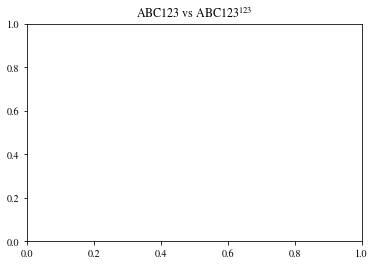

In [1]:
import pandas as pd
import numpy as np
import sys
import copy

import matplotlib.pyplot as plt
%matplotlib inline
# To change the default font like latex font
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

import itertools
import scipy.stats as stats

In [2]:
def countCommas(s):
    try:
        return s.count(',')
    except:
        return np.nan

# Content

- [Data Import](#Data-Import)
- [Define functions and important variables](#Define-functions-and-important-variables)
- [Start Data Analysis](#Start-Data-Analysis)


# Data Import

Raw Data 

-[Return](#Content)

In [3]:
## Pilot data

# data = pd.DataFrame()
# s = { 
# #     'all_apps_wide_2022-11-04.csv': 'HETERO',
#         'all_apps_wide_2022-11-07.csv': 'HETERO' ,
#       'all_apps_wide_2022-11-07b.csv': 'HOMO' }
# for ss in s.keys() :
    
#     temp = pd.read_csv('..\\RawData\\'+ss)
#     temp['Treatment'] = s[ss]
#     data = data.append(temp,  ignore_index = True)

# data_pilot = data

In [5]:
data = pd.DataFrame()
s = { 
        '2022_12_01_reals01.csv': ['HETERO', 20], 
    '2022_12_01_reals02.csv': ['HETERO', 80], 
    '2022_12_01_reals03.csv': ['HOMO', 20], 
    '2022_12_02_reals04.csv': ['HOMO', 80], 
}
    
for ss in s.keys() :
    
    temp = pd.read_csv('..\\RawData\\'+ss)
    temp['Treatment'] = s[ss][0]
    temp['FC'] = s[ss][1]
    data = data.append(temp,  ignore_index = True)

data_ABA = data

In [6]:
data = pd.DataFrame()
s = { 
        '2022_12_06_reals05.csv': ['HETERO', 80], 
    '2022_12_06_reals06.csv': ['HETERO', 20],
    '2022_12_06_reals07.csv': ['HOMO', 80],
    '2022_12_06_reals08.csv': ['HOMO', 20],
}
    
for ss in s.keys() :
    
    temp = pd.read_csv('..\\RawData\\'+ss)
    temp['Treatment'] = s[ss][0]
    temp['FC'] = s[ss][1]
    data = data.append(temp,  ignore_index = True)

data_BAB = data

In [9]:
data_ABA.to_csv('..\\RawData\\data_ABA.csv',index=False)
data_BAB.to_csv('..\\RawData\\data_BAB.csv',index=False)

# Define functions and important variables 

-[Return](#Content)


In [22]:
variables = [ 'subsession.round_number','subsession.period', 'subsession.sg', 
#              'session.code','participant.code',
             'player.id_in_group','player.endowment', 'player.join_club', 
             'player.local_community', 'player.id_in_local', 
             'player.contribution_local', 'player.contribution_global',
             'player.total_contribution_local', 'player.individual_share_local', 'player.payoff',
           'group.id_in_subsession', 'group.FC', 'group.total_contribution_global','group.individual_share_global',
            ]


In [23]:
# Cut out data, by AppName and Length

def DataCutOutLong(data, AppName, endRound):
    col_noOpp = AppName
    col_name_a =   ['session.code', 'Treatment', 'FC']
    data_noOppor = pd.DataFrame()
    for i in range(1,endRound+1):
        col_names = [col_noOpp+'.'+str(i)+'.'+ x for x in variables]
        col_rename = {}
        for x in variables:
            col_rename[col_noOpp+'.'+str(i)+'.'+ x ] =  x
        temp = data[col_names + col_name_a]
        temp = temp.rename(columns=col_rename) 
        data_noOppor = data_noOppor.append(temp, ignore_index=True)
    data_noOppor['endowment'] = data_noOppor['player.endowment']/10
    data_noOppor['tot_contr'] = data_noOppor['player.contribution_local']+data_noOppor['player.contribution_global']
    data_noOppor['privateAcc'] = data_noOppor['player.endowment']/10 - data_noOppor['player.contribution_local']-data_noOppor['player.contribution_global'] # note: endowment has counted subjects' joining behavior 
    data_noOppor['player.payoff'] = data_noOppor['player.payoff']/10
    return data_noOppor

In [24]:
AppName = 'PGSO_05BAB_ClubOpp_Par2BBB'
endRound = 10


col_noOpp = AppName
col_name_a =   ['session.code', 'Treatment', 'FC']
data_noOppor = pd.DataFrame()
for i in range(1,endRound+1):
    col_names = [col_noOpp+'.'+str(i)+'.'+ x for x in variables]
    col_rename = {}
    for x in variables:
        col_rename[col_noOpp+'.'+str(i)+'.'+ x ] =  x
    temp = data[col_names + col_name_a]
    temp = temp.rename(columns=col_rename) 
    data_noOppor = data_noOppor.append(temp, ignore_index=True)

In [25]:
B1 = DataCutOutLong(data_ABA, 'PGSO_08ABA_ClubOpp_Par3BBB',50)
B1

In [27]:
def bootstrap_ci(data, n_samples, stat):
    
    n = len(data)                                #get length of the data
    ix = np.random.randint(0, n, (n_samples, n)) #get an array of bootsrapped indices
    samples = data[ix]                           #create bootrapped samples
    
    distribution = stat(samples, axis=1)

    return (np.percentile(distribution,2.5),np.percentile(distribution,97.5))

In [28]:
def permutation_test_r(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    original_stat=np.mean(sample1)-np.mean(sample2)
    print("Original Statistic:",original_stat)
    combined=np.append(sample1,sample2)
    #print combined
    permutations=np.matrix(list(itertools.permutations(combined)))
    print(permutations)
    n_permut=len(permutations)
    print("Number of permutations:",len(permutations))
    distr=permutations[:,0:n1].mean(axis=1)-permutations[:,n1:n1+n2].mean(axis=1)
    count=(distr<=original_stat).sum()
    print("Count: ",count," out of ",n_permut)
    p_val=np.round(float(count)/float(n_permut),3)
    print("Probability: ",p_val)

In [45]:
def permutation_test(pop_a, pop_b):

    original_statistics = pop_a.mean() - pop_b.mean()
    print(original_statistics)

    print('# 2. use permutation test (non-parametric test)' )
    n1 = len(pop_a)
    n2 = len(pop_b)
    
    sim_num = 10000
    
    combined = np.append(pop_a, pop_b)
#     permutationss=np.matrix(list(permutations(combined)))
#     n_permut=len(permutationss)
    n = len(combined)
    idx = np.arange(n)
    sim_d = []
    for i in range(sim_num):
        np.random.shuffle(idx)
        d = np.mean(combined[idx][0:n1]) - np.mean(combined[idx][n1::])
    #     print(d)
        sim_d.append(d)
    # calculate the p-value for two-sided test:
    count = (np.abs(sim_d)>=np.abs(original_statistics)).sum()
    # calculate the one-sided test, first-second
#     count = (np.array(sim_d)>=original_statistics).sum()
#     print(count)
    p_val = np.round((count+1)/(sim_num+1), 3)
    print("p-value for two-sided test", p_val)
    
#     distr=np.array(np.ma.mean(permutationss[:,0:n1],1)-np.ma.mean(permutationss[:,n1:n1+n2],1))
# #     count=(distr<=original_statistics).sum()
#     count=(np.abs(distr)>=np.abs(original_statistics)).sum()
#     print("Permutation Count: ",count," out of ",n_permut)
#     p_val=np.round(float(count)/float(n_permut),3)
#     print("two-sided Probability: ",p_val)


# Group Data

Sequence : [7, 6, 18, 17, 13, 8, 12, 7]

A1 = [7] (10 rounds)

B1 = [6,18,17]

A2 = [13]

B2 = [8]

-[Order Effect](#Order-effect)

-[Compare Local and Global](#Compare-Local-and-Global)

-[Return](#Content)


In [30]:
A1 = DataCutOutLong(data_ABA, 'PGSO_05ABA_PurePG_Part2A',10)
A1['Sequence'] = 'A1'
A2 = DataCutOutLong(data_ABA, 'PGSO_09ABA_PurePG_Part4A',20)
A2['Sequence'] = 'A2'
B1 = DataCutOutLong(data_ABA, 'PGSO_08ABA_ClubOpp_Par3BBB',50)
B1['Sequence'] = 'B1'

B1_bab = DataCutOutLong(data_BAB, 'PGSO_05BAB_ClubOpp_Par2BBB',50)
B1_bab['Sequence'] = 'B1_bab'
A2_bab = DataCutOutLong(data_BAB, 'PGSO_08BAB_PurePG_Part3A',20)
A2_bab['Sequence'] = 'A2_bab'
B2_bab = DataCutOutLong(data_BAB, 'PGSO_09BAB_PurePG_Part4B',10)
B2_bab['Sequence'] = 'B2_bab'
# A2 = pd.concat([A2, A2_bab], ignore_index=True)
# B1 = 

In [ ]:
# Data with opportunity
data_Oppor = pd.concat([B1, B1_bab], ignore_index=True)
# data_Oppor = pd.concat([B1, B1_bab,B2_bab], ignore_index=True)
# data_Oppor = pd.concat([B1, B1_bab], ignore_index=True)



GroupRound = data_Oppor.groupby(['group.id_in_subsession', #'player.local_community',
                                  'session.code','subsession.sg',
                                  'Treatment','FC','Sequence',
                                  'subsession.round_number'])['tot_contr',  'privateAcc', 'player.payoff','player.contribution_local','player.contribution_global' ].sum().reset_index()

MatchAverage = GroupRound.groupby(['group.id_in_subsession', 'subsession.sg', #'player.local_community',
                                  'session.code',
                                  'Treatment','FC','Sequence'])['tot_contr',  'privateAcc', 'player.payoff','player.contribution_local','player.contribution_global' ].mean().reset_index()
CompareBoth = MatchAverage
# pd.pivot_table(data_Oppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC','Sequence'],
#                     columns=['subsession.round_number'], aggfunc=np.sum, fill_value=np.nan)

CompareBoth.groupby(['Treatment','FC','Sequence'])['tot_contr'].agg(['mean','std'])
# LocalOnly.groupby(['Treatment','FC']).mean() # Note: if only A2 and A2_bab, contribution: downward trending is apparent; added A1, not very apparent (Hetero 20 upward trending?)


In [32]:
data_Oppor = pd.concat([B1, B1_bab], ignore_index=True)



GroupRound = data_Oppor.groupby(['group.id_in_subsession', #'player.local_community',
                                  'session.code','subsession.sg',
                                  'Treatment','FC','Sequence',
                                  'subsession.round_number'])['tot_contr',  'privateAcc', 'player.payoff','player.contribution_local','player.contribution_global' ].sum().reset_index()

MatchAverage = GroupRound.groupby(['group.id_in_subsession', 'subsession.sg', #'player.local_community',
                                  'session.code',
                                  'Treatment','FC','Sequence'])['tot_contr',  'privateAcc', 'player.payoff','player.contribution_local','player.contribution_global' ].mean().reset_index()
CompareBoth = MatchAverage
# pd.pivot_table(data_Oppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC','Sequence'],
#                     columns=['subsession.round_number'], aggfunc=np.sum, fill_value=np.nan)

CompareBoth.groupby(['Treatment','FC','Sequence'])['tot_contr'].agg(['mean','std'])
# LocalOnly.groupby(['Treatment','FC']).mean() # Note: if only A2 and A2_bab, contribution: downward trending is apparent; added A1, not very apparent (Hetero 20 upward trending?)

C:\Users\xinxi\AppData\Local\Temp/ipykernel_13396/582513026.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  GroupRound = data_Oppor.groupby(['group.id_in_subsession', #'player.local_community',
C:\Users\xinxi\AppData\Local\Temp/ipykernel_13396/582513026.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  MatchAverage = GroupRound.groupby(['group.id_in_subsession', 'subsession.sg', #'player.local_community',


mean        std
Treatment FC Sequence                      
HETERO    20 B1        70.250000  32.850266
             B1_bab    56.025000  12.087132
          80 B1        46.683333  13.416358
             B1_bab    58.191667  18.994563
HOMO      20 B1        56.466667  14.961874
             B1_bab    69.850000  14.884220
          80 B1        32.158333  21.343276
             B1_bab    65.941667  14.874522

In [33]:
# var_of_interest = 'player.contribution_local'
# var_of_interest = 'player.payoff'
# var_of_interest = 'privateAcc'
var_of_interest =  'tot_contr'
condition = (CompareBoth['Treatment']=='HOMO') & (CompareBoth['FC']==80)
groupA = CompareBoth.loc[condition &(CompareBoth['Sequence']=='B1'),var_of_interest]
groupB = CompareBoth.loc[condition&(CompareBoth['Sequence']=='B1_bab'),var_of_interest]

In [36]:
# ttest(groupA, groupB, correction = False)
stats.ttest_ind(groupA, groupB)

Ttest_indResult(statistic=-3.180915797413431, pvalue=0.009804191454957867)

In [37]:
stats.ranksums(groupA, groupB)

RanksumsResult(statistic=-2.24179415327122, pvalue=0.024974679293054237)

In [46]:
permutation_test(groupA, groupB)

-33.783333333333346
# 2. use permutation test (non-parametric test)
p-value for two-sided test 0.018


## Compare Local and Global



In [44]:
# data_noOppor = pd.concat([A1])
# data_noOppor = pd.concat([A2, A2_bab], ignore_index=True)
data_noOppor = pd.concat([A1, A2, A2_bab], ignore_index=True)

# var_of_interest = 'player.contribution_local'
# var_of_interest = 'player.payoff'
# var_of_interest = 'privateAcc'
var_of_interest =  'tot_contr'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC','Sequence'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=np.nan)

LocalOnly.groupby(['Treatment','FC','Sequence']).mean()
LocalOnly.groupby(['Treatment','FC']).mean() # Note: if only A2 and A2_bab, contribution: downward trending is apparent; added A1, not very apparent (Hetero 20 upward trending?)

subsession.round_number         1          2          3          4   \
Treatment FC                                                          
HETERO    20             30.666667  34.000000  33.000000  36.166667   
          80             37.000000  34.416667  29.916667  30.000000   
HOMO      20             35.500000  33.333333  31.833333  32.583333   
          80             37.750000  39.833333  39.250000  39.333333   

subsession.round_number         5          6          7          8   \
Treatment FC                                                          
HETERO    20             35.916667  36.250000  36.083333  34.666667   
          80             32.166667  31.000000  30.583333  31.500000   
HOMO      20             30.666667  29.916667  31.083333  29.166667   
          80             37.916667  39.166667  33.000000  33.916667   

subsession.round_number         9          10      11     12      13      14  \
Treatment FC                                                                   
HETERO    20             35.166667  34.250000  42.000  39.50  39.125  40.250   
          80             28.333333  27.583333  27.250  26.75  30.250  29.375   
HOMO      20             25.916667  27.750000  36.625  37.00  35.000  32.125   
          80             33.916667  30.500000  45.250  42.50  44.250  42.625   

subsession.round_number      15      16      17      18      19      20  
Treatment FC                                                             
HETERO    20             39.750  41.125  42.375  42.125  42.875  39.750  
          80             29.875  30.000  26.625  26.375  25.750  25.500  
HOMO      20             25.750  25.750  28.375  27.250  26.625  25.625  
          80             42.250  37.500  41.250  38.500  38.250  35.375

In [45]:
# data_noOppor = pd.concat([A1])
# data_noOppor = pd.concat([A2, A2_bab], ignore_index=True)
data_noOppor = pd.concat([A1, A2, A2_bab], ignore_index=True)

# var_of_interest = 'player.contribution_local'
# var_of_interest = 'player.payoff'
# var_of_interest = 'privateAcc'
var_of_interest =  'tot_contr'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC','Sequence'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=np.nan)

LocalOnly.groupby(['Treatment','FC','Sequence']).mean()
LocalOnly.groupby(['Treatment','FC']).mean() # Note: if only A2 and A2_bab, contribution: downward trending is apparent; added A1, not very apparent (Hetero 20 upward trending?)

subsession.round_number         1          2          3          4   \
Treatment FC                                                          
HETERO    20             30.666667  34.000000  33.000000  36.166667   
          80             37.000000  34.416667  29.916667  30.000000   
HOMO      20             35.500000  33.333333  31.833333  32.583333   
          80             37.750000  39.833333  39.250000  39.333333   

subsession.round_number         5          6          7          8   \
Treatment FC                                                          
HETERO    20             35.916667  36.250000  36.083333  34.666667   
          80             32.166667  31.000000  30.583333  31.500000   
HOMO      20             30.666667  29.916667  31.083333  29.166667   
          80             37.916667  39.166667  33.000000  33.916667   

subsession.round_number         9          10      11     12      13      14  \
Treatment FC                                                                   
HETERO    20             35.166667  34.250000  42.000  39.50  39.125  40.250   
          80             28.333333  27.583333  27.250  26.75  30.250  29.375   
HOMO      20             25.916667  27.750000  36.625  37.00  35.000  32.125   
          80             33.916667  30.500000  45.250  42.50  44.250  42.625   

subsession.round_number      15      16      17      18      19      20  
Treatment FC                                                             
HETERO    20             39.750  41.125  42.375  42.125  42.875  39.750  
          80             29.875  30.000  26.625  26.375  25.750  25.500  
HOMO      20             25.750  25.750  28.375  27.250  26.625  25.625  
          80             42.250  37.500  41.250  38.500  38.250  35.375

In [151]:
LocalOnly.sort_values(['Sequence', 'Treatment', 'FC']) # To check each treatment, how much variations within each treatment/sessions
LocalOnly.sort_values([ 'Treatment', 'FC', 'player.local_community','Sequence',]) # To check how consistent each group is 

subsession.round_number                                       1      2   \
player.local_community session.code Treatment FC Sequence                 
0                      9xes1nai     HETERO    20 A2        126.2  138.8   
                       dbs7jo4s     HETERO    20 A2_bab    145.8  117.8   
1                      9xes1nai     HETERO    20 A2        129.0  140.2   
                       dbs7jo4s     HETERO    20 A2_bab    103.8  115.0   
2                      9xes1nai     HETERO    20 A2        143.0  171.0   
                       dbs7jo4s     HETERO    20 A2_bab     92.6   92.6   
3                      9xes1nai     HETERO    20 A2        165.4  171.0   
                       dbs7jo4s     HETERO    20 A2_bab    101.0  116.4   
0                      2fgmodqt     HETERO    80 A2        115.0  120.6   
                       yguj0voh     HETERO    80 A2_bab    130.4  131.8   
1                      2fgmodqt     HETERO    80 A2        136.0  108.0   
                       yguj0voh     HETERO    80 A2_bab    136.0  140.2   
2                      2fgmodqt     HETERO    80 A2        115.0  115.0   
                       yguj0voh     HETERO    80 A2_bab     92.6   92.6   
3                      2fgmodqt     HETERO    80 A2        138.8  140.2   
                       yguj0voh     HETERO    80 A2_bab    164.0  164.0   
0                      4pr9j0gm     HOMO      20 A2        151.4  161.2   
                       ic1q244g     HOMO      20 A2_bab    151.4  137.4   
1                      4pr9j0gm     HOMO      20 A2        105.2   88.4   
                       ic1q244g     HOMO      20 A2_bab    133.2  136.0   
2                      4pr9j0gm     HOMO      20 A2        144.4  150.0   
                       ic1q244g     HOMO      20 A2_bab    137.4  143.0   
3                      4pr9j0gm     HOMO      20 A2        103.8   98.2   
                       ic1q244g     HOMO      20 A2_bab    136.0  144.4   
0                      0eg86j32     HOMO      80 A2         84.2   80.0   
                       xiwi1u7k     HOMO      80 A2_bab    172.4  183.6   
1                      0eg86j32     HOMO      80 A2         80.0   80.0   
                       xiwi1u7k     HOMO      80 A2_bab    112.2  115.0   
2                      0eg86j32     HOMO      80 A2        157.0  171.0   
                       xiwi1u7k     HOMO      80 A2_bab    178.0  192.0   
3                      0eg86j32     HOMO      80 A2        136.0  143.0   
                       xiwi1u7k     HOMO      80 A2_bab    165.4  140.2   

subsession.round_number                                       3      4   \
player.local_community session.code Treatment FC Sequence                 
0                      9xes1nai     HETERO    20 A2        145.8  148.6   
                       dbs7jo4s     HETERO    20 A2_bab    112.2  122.0   
1                      9xes1nai     HETERO    20 A2        123.4  133.2   
                       dbs7jo4s     HETERO    20 A2_bab    102.4  109.4   
2                      9xes1nai     HETERO    20 A2        192.0  154.2   
                       dbs7jo4s     HETERO    20 A2_bab     95.4   99.6   
3                      9xes1nai     HETERO    20 A2        171.0  178.0   
                       dbs7jo4s     HETERO    20 A2_bab    102.4  117.8   
0                      2fgmodqt     HETERO    80 A2        113.6  113.6   
                       yguj0voh     HETERO    80 A2_bab    124.8  130.4   
1                      2fgmodqt     HETERO    80 A2        115.0  115.0   
                       yguj0voh     HETERO    80 A2_bab    138.8  137.4   
2                      2fgmodqt     HETERO    80 A2        117.8  116.4   
                       yguj0voh     HETERO    80 A2_bab     89.8   89.8   
3                      2fgmodqt     HETERO    80 A2        116.4  116.4   
                       yguj0voh     HETERO    80 A2_bab    172.4  155.6   
0                      4pr9j0gm     HOMO      20 A2        166.8  185.0   
                       i

In [46]:
data_noOppor.groupby([ 
                      'Treatment',
#     'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number'])[var_of_interest].mean()
# plot.line()

Treatment  FC  Sequence  subsession.round_number
HETERO     20  A1        1                           6.6250
                         2                           6.6250
                         3                           6.6875
                         4                           8.2500
                         5                           8.2500
                                                     ...   
HOMO       80  A2_bab    16                         11.7500
                         17                         13.7500
                         18                         12.4375
                         19                         12.3750
                         20                         11.8750
Name: tot_contr, Length: 200, dtype: float64

In [47]:
def B_round_number_transfor(x):
    y = x
    if x>10 and x<=30:
        y = x-10
    elif x>30:
        y = x-30
    return y
 # Actually it corresponds to period in the data        

In [51]:
# Note: when analyzing the global club good, can't use local community as the unit, use the whole group
# data_Oppor = B1
data_Oppor = pd.concat([B1, B1_bab,B2_bab], ignore_index=True)
# data_Oppor = pd.concat([B1, B1_bab], ignore_index=True)

# For the 50 rounds in B setting, need to divide into 3 big groups
data_Oppor['subsession.round_number_o'] = data_Oppor['subsession.round_number']
data_Oppor['subsession.round_number'] = data_Oppor['subsession.round_number'].apply(B_round_number_transfor)


# var_of_interest = 'player.contribution_local'
# var_of_interest = 'privateAcc'
var_of_interest =  'tot_contr'

LocalGlobal = pd.pivot_table(data_Oppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number_o'], aggfunc=np.sum, fill_value=np.nan)

LocalGlobal.groupby(['Treatment','FC']).mean()

subsession.round_number_o      1      2       3       4       5       6   \
Treatment FC                                                               
HETERO    20               45.500  45.25  46.125  43.500  46.875  48.875   
          80               37.625  31.25  25.000  34.250  35.625  33.625   
HOMO      20               56.000  53.25  53.000  52.875  50.750  47.625   
          80               47.750  42.00  46.125  51.000  45.875  49.375   

subsession.round_number_o      7       8       9       10  ...      41  \
Treatment FC                                               ...           
HETERO    20               48.250  46.000  44.625  41.875  ...  37.625   
          80               38.750  39.000  33.250  36.250  ...  26.750   
HOMO      20               52.500  50.875  47.625  43.250  ...  30.500   
          80               44.875  51.500  46.375  46.750  ...  25.625   

subsession.round_number_o      42      43      44      45      46      47  \
Treatment FC                                                                
HETERO    20               36.250  34.625  35.500  34.625  33.750  33.250   
          80               27.375  28.000  26.250  28.250  29.750  28.750   
HOMO      20               30.750  32.000  34.375  34.500  33.875  33.875   
          80               27.375  25.625  24.500  21.875  22.375  22.375   

subsession.round_number_o      48      49      50  
Treatment FC                                       
HETERO    20               33.000  27.875  28.875  
          80               29.625  29.875  26.500  
HOMO      20               32.750  32.375  33.875  
          80               25.500  27.250  25.125  

[4 rows x 50 columns]

In [160]:
var_of_interest = 'player.contribution_global'
# var_of_interest = 'privateAcc'

LocalGlobal = pd.pivot_table(data_Oppor, values=var_of_interest, index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=np.nan)

LocalGlobal.groupby(['Treatment','FC']).mean()  # when the FC is small and hetero, the contribution is relatively stable;
    # when the FC is small and homo, the contribution decrease;
    # when FC is large, both hetero and homo decreases (but hetero move to local? homo doesn't? )
    
    # Need to calculate confidence interval!! group as individual unit, may have very large confidence interval!!!)
    # If interval is too big, need to use the simulation result to help make predictions!!!!

subsession.round_number      1       2       3       4       5       6   \
Treatment FC                                                              
HETERO    20             70.625  73.875  78.625  76.375  80.750  78.125   
          80             38.000  34.875  24.500  24.875  21.250  14.000   
HOMO      20             84.625  77.875  76.875  68.500  69.875  68.375   
          80             55.875  55.500  56.750  59.875  58.250  52.875   

subsession.round_number      7       8       9       10      11      12  \
Treatment FC                                                              
HETERO    20             75.375  76.250  75.625  70.000  49.125  49.250   
          80             17.250  13.750  10.750   9.000   6.125   3.250   
HOMO      20             70.625  71.375  68.750  68.375  52.875  54.500   
          80             43.375  42.125  39.375  36.125  34.375  36.625   

subsession.round_number      13      14      15      16      17      18  \
Treatment FC                                                              
HETERO    20             51.000  51.375  51.625  47.625  47.125  45.125   
          80              3.250   2.000   2.000   1.875   0.625   0.125   
HOMO      20             54.000  58.750  56.625  53.500  52.125  49.875   
          80             40.625  39.000  35.375  32.250  33.625  33.500   

subsession.round_number      19      20  
Treatment FC                             
HETERO    20             39.375  29.125  
          80              0.000   0.000  
HOMO      20             46.250  53.125  
          80             29.000  26.125

In [147]:
# Group Level data
Group_NoOpp = data_noOppor.groupby(['player.local_community', 'Sequence',
                                    'session.code', 'Treatment','FC',
                                    'subsession.round_number', 
                                    'subsession.period'])['player.contribution_local',
                                                          'endowment', 'tot_contr',
                                                          'privateAcc',
                                                         'player.payoff',
                                                          'player.join_club',
                                                        ].sum().reset_index()


Group_Opp = data_Oppor.groupby(['player.local_community', 'Sequence',
                                    'session.code', 'Treatment', 'FC',
                                    'subsession.round_number','subsession.round_number_o',
                                    'subsession.period'])['player.contribution_local',
                                                          'player.contribution_global',
                                                          'endowment', 'tot_contr',
                                                          'privateAcc',
                                                         'player.payoff',
                                                         'player.join_club'].sum().reset_index()


# data_Oppor.
# Group_NoOpp


C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/636255410.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Group_NoOpp = data_noOppor.groupby(['player.local_community', 'Sequence',
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/636255410.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Group_Opp = data_Oppor.groupby(['player.local_community', 'Sequence',


In [148]:
Group_Opp.groupby(['Treatment','FC'])['player.payoff'].agg(['mean']).reset_index()

,Treatment,FC,mean
0,HETERO,20,172.244545
1,HETERO,80,115.969545
2,HOMO,20,176.055000
3,HOMO,80,128.492273


In [149]:
Group_NoOpp.groupby(['Treatment','FC'])['player.payoff'].agg(['mean']).reset_index()

,Treatment,FC,mean
0,HETERO,20,131.975
1,HETERO,80,121.804
2,HOMO,20,122.658
3,HOMO,80,133.459


In [150]:
# Draw a graph to show the total contribution without vs with opportunity 

Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr',
                                                                    'player.contribution_global',
                                                                   'player.payoff', 'player.join_club'].mean().reset_index()
# Contribution_Combined =pd.pivot_table(Group_Opp, values=['player.contribution_local','player.contribution_global'], 
#               index=['Treatment'],columns=['group.FC'] ).reset_index()
temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr', 'player.payoff', 'player.join_club'].mean().reset_index()
Contribution_Combined = Contribution_Combined.merge(temp, on=['Treatment','FC'])

Contribution_Combined_std = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local',
                                                                    'player.contribution_global','tot_contr',].std().reset_index()
temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local', 'tot_contr'].std().reset_index()
Contribution_Combined_std = Contribution_Combined_std.merge(temp, on=['Treatment','FC'])

# Try s.e.
Contribution_Combined_std['player.contribution_local_x']=Contribution_Combined_std['player.contribution_local_x']/np.sqrt(80)
Contribution_Combined_std['player.contribution_local_y']=Contribution_Combined_std['player.contribution_local_y']/np.sqrt(20)
Contribution_Combined_std['player.contribution_global']=Contribution_Combined_std['player.contribution_global']/np.sqrt(80)

C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/3963545994.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr',
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/3963545994.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr', 'player.payoff', 'player.join_club'].mean().reset_index()
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/3963545994.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Contribution_Combined_std = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local',
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/3963545994.py:13: FutureWar

In [154]:
Contribution_Combined_CI9 = copy.deepcopy(Contribution_Combined)

for t in Contribution_Combined.Treatment.unique():
    for fc in Contribution_Combined['FC'].unique():
        data = Group_NoOpp[(Group_NoOpp['Treatment']==t) & (Group_NoOpp['FC']==fc)]
        x = bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0] 

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                      'player.contribution_local_y'] -= x

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                      'player.payoff_y'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
        
        data = Group_Opp[(Group_Opp['Treatment']==t) & (Group_Opp['FC']==fc)]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc),
                                      'player.contribution_local_x'] -= bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) 
                                      & (Contribution_Combined_CI9['FC']==fc), 
                                      'player.contribution_global'] -= bootstrap_ci(np.array(data['player.contribution_global']), 10000, np.mean)[0]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc), 
                                  'player.payoff_x'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc), 
                                   'player.join_club_x'] -= bootstrap_ci(np.array(data['player.join_club']), 10000, np.mean)[0] 
    
    

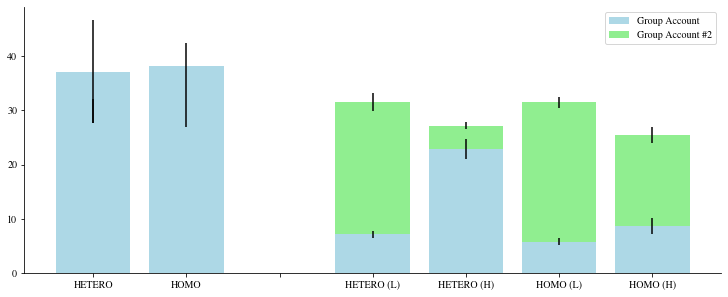

In [155]:
labels=  ['HETERO', 'HOMO', '','HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.bar(Contribution_Combined.Treatment, Contribution_Combined['player.contribution_local_y'], 
         label="Group Account", 
         yerr=Contribution_Combined_CI9['player.contribution_local_y'], 
#          yerr=Contribution_Combined_std['player.contribution_local_y'],
         color='lightblue')

axes.bar(Contribution_Combined.index+3, Contribution_Combined['player.contribution_local_x'],
#          label="Group Account",
         yerr=Contribution_Combined_CI9['player.contribution_local_x'],
#          yerr=Contribution_Combined_std['player.contribution_local_x'],
         color='lightblue')
# Stacked bars
axes.bar(Contribution_Combined.index+3,
         Contribution_Combined['player.contribution_global'], label="Group Account #2", 
         bottom=Contribution_Combined['player.contribution_local_x'],
#         yerr=Contribution_Combined_std['player.contribution_global'],
         yerr=Contribution_Combined_CI9['player.contribution_global'],
         color='lightgreen')

axes.set_xticks(labels)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-Contribution.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

In [162]:
# Draw a graph to show the total contribution without vs with opportunity 
def ContributionGraph(Group_Opp, Group_NoOpp):
    Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr',
                                                                        'player.contribution_global',
                                                                       'player.payoff', 'player.join_club'].mean().reset_index()
    # Contribution_Combined =pd.pivot_table(Group_Opp, values=['player.contribution_local','player.contribution_global'], 
    #               index=['Treatment'],columns=['group.FC'] ).reset_index()
    temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr', 'player.payoff', 'player.join_club'].mean().reset_index()
    Contribution_Combined = Contribution_Combined.merge(temp, on=['Treatment','FC'])

    Contribution_Combined_std = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local',
                                                                        'player.contribution_global','tot_contr',].std().reset_index()
    temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local', 'tot_contr'].std().reset_index()
    Contribution_Combined_std = Contribution_Combined_std.merge(temp, on=['Treatment','FC'])

    # Try s.e.
    Contribution_Combined_std['player.contribution_local_x']=Contribution_Combined_std['player.contribution_local_x']/np.sqrt(80)
    Contribution_Combined_std['player.contribution_local_y']=Contribution_Combined_std['player.contribution_local_y']/np.sqrt(20)
    Contribution_Combined_std['player.contribution_global']=Contribution_Combined_std['player.contribution_global']/np.sqrt(80)
    Contribution_Combined_CI9 = copy.deepcopy(Contribution_Combined)

    for t in Contribution_Combined.Treatment.unique():
        for fc in Contribution_Combined['FC'].unique():
            data = Group_NoOpp[(Group_NoOpp['Treatment']==t) & (Group_NoOpp['FC']==fc)]
            x = bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0] 

            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                          'player.contribution_local_y'] -= x

            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t)  & (Group_NoOpp['FC']==fc), 
                                          'player.payoff_y'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 

            data = Group_Opp[(Group_Opp['Treatment']==t) & (Group_Opp['FC']==fc)]
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                          (Contribution_Combined_CI9['FC']==fc),
                                          'player.contribution_local_x'] -= bootstrap_ci(np.array(data['player.contribution_local']), 10000, np.mean)[0]
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) 
                                          & (Contribution_Combined_CI9['FC']==fc), 
                                          'player.contribution_global'] -= bootstrap_ci(np.array(data['player.contribution_global']), 10000, np.mean)[0]
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                          (Contribution_Combined_CI9['FC']==fc), 
                                      'player.payoff_x'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
            Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                          (Contribution_Combined_CI9['FC']==fc), 
                                       'player.join_club_x'] -= bootstrap_ci(np.array(data['player.join_club']), 10000, np.mean)[0] 

    labels=  ['HETERO', 'HOMO', '','HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
    x = np.arange(len(labels))
    fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

    axes.bar(Contribution_Combined.Treatment, Contribution_Combined['player.contribution_local_y'], 
             label="Group Account", 
             yerr=Contribution_Combined_CI9['player.contribution_local_y'], 
    #          yerr=Contribution_Combined_std['player.contribution_local_y'],
             color='lightblue')

    axes.bar(Contribution_Combined.index+3, Contribution_Combined['player.contribution_local_x'],
    #          label="Group Account",
             yerr=Contribution_Combined_CI9['player.contribution_local_x'],
    #          yerr=Contribution_Combined_std['player.contribution_local_x'],
             color='lightblue')
    # Stacked bars
    axes.bar(Contribution_Combined.index+3,
             Contribution_Combined['player.contribution_global'], label="Group Account #2", 
             bottom=Contribution_Combined['player.contribution_local_x'],
    #         yerr=Contribution_Combined_std['player.contribution_global'],
             yerr=Contribution_Combined_CI9['player.contribution_global'],
             color='lightgreen')

    axes.set_xticks(labels)
    axes.legend()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    # fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-Contribution.pdf'  , bbox_inches="tight")  
    # fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/54272486.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr',
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/54272486.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = Group_NoOpp.groupby(['Treatment','FC'])['player.contribution_local','tot_contr', 'player.payoff', 'player.join_club'].mean().reset_index()
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/54272486.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Contribution_Combined_std = Group_Opp.groupby(['Treatment','FC'])['player.contribution_local',
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/54272486.py:13: FutureWarning: In

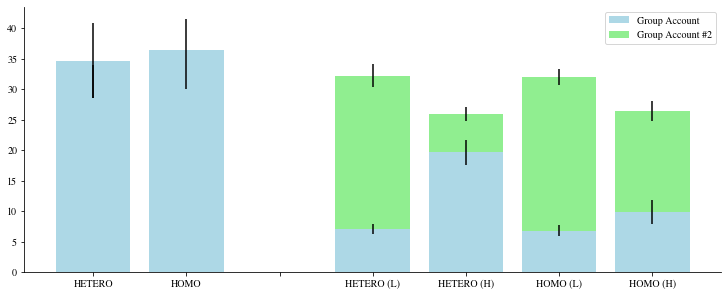

In [164]:
ContributionGraph(Group_Opp[Group_Opp['subsession.period']<=10], Group_NoOpp[Group_NoOpp['subsession.period']<=10] )

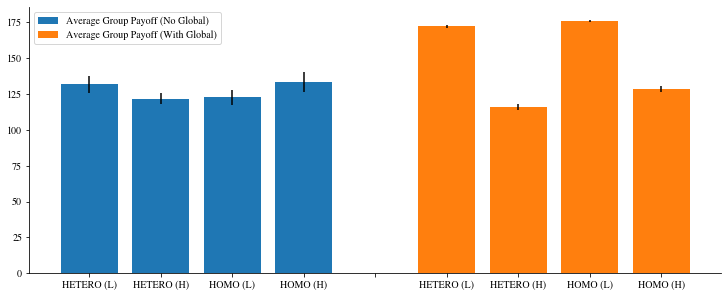

In [158]:
# Draw a graph to show the average player payoff without vs with opportunity 


labels=  ['HETERO (L)', 'HETERO (H)','HOMO (L)', 'HOMO (H)', '', 'HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.bar(Contribution_Combined.index, Contribution_Combined['player.payoff_y'], 
         label="Average Group Payoff (No Global)", 
#          yerr=Contribution_Combined_CI9['player.payoff_y'], 
         yerr=Contribution_Combined_std['player.contribution_local_y'],
#          color='lightblue'
        )

axes.bar(Contribution_Combined.index+5, Contribution_Combined['player.payoff_x'],
         label="Average Group Payoff (With Global)", 
#          yerr=Contribution_Combined_CI9['player.payoff_x'],
         yerr=Contribution_Combined_std['player.contribution_local_x'],
#          color='lightblue'
        )

# axes.axhline(y=80, linestyle='dashed')

axes.set_xticks(x)
axes.set_xticklabels(labels)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-Payoff.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

No handles with labels found to put in legend.


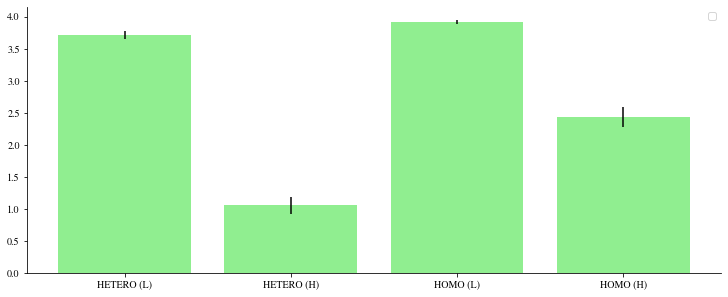

In [124]:
# Draw a graph to show the number of players who join the club with opportunity 


labels=  ['HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.bar(list(Contribution_Combined.index), Contribution_Combined['player.join_club_x'],
#          label="Group Account",
         yerr=Contribution_Combined_CI9['player.join_club_x'],
#          yerr=Contribution_Combined_std['player.contribution_local_x'],
         color='lightgreen')

axes.set_xticks(ticks=list(Contribution_Combined.index))
axes.set_xticklabels(labels)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-NumJoinClubInEachGroup.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

## Group Level data, inequality

C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/271721746.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Group_NoOpp = data_noOppor.groupby(['player.local_community',
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/271721746.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Group_Opp = data_Oppor.groupby(['player.local_community',
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/271721746.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['endowment','player.payoff'].mean().reset_index()
C:\Users\xinxi\AppData\Local\Temp/ipykernel_3632/271721746.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

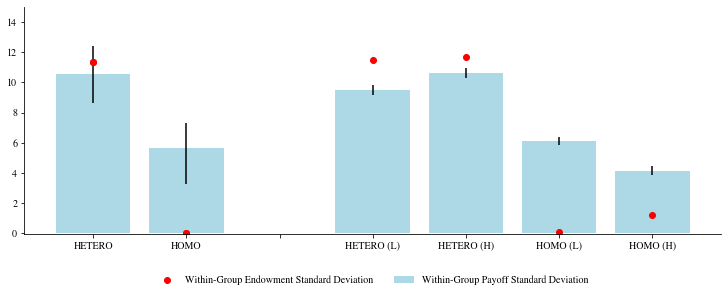

In [125]:
# Group Level data
Group_NoOpp = data_noOppor.groupby(['player.local_community', 
                                    'session.code', 'Treatment','FC',
                                    'subsession.round_number',
                                    'subsession.period'])['endowment',
                                                         'player.payoff',
                                                        ].std().reset_index()


Group_Opp = data_Oppor.groupby(['player.local_community', 
                                    'session.code', 'Treatment', 'FC',
                                    'subsession.round_number', 'subsession.round_number_o',
                                    'subsession.period'])['endowment','player.payoff'].std().reset_index()


Contribution_Combined = Group_Opp.groupby(['Treatment','FC'])['endowment','player.payoff'].mean().reset_index()
# Contribution_Combined =pd.pivot_table(Group_Opp, values=['player.contribution_local','player.contribution_global'], 
#               index=['Treatment'],columns=['group.FC'] ).reset_index()
temp = Group_NoOpp.groupby(['Treatment','FC'])['endowment','player.payoff'].mean().reset_index()
Contribution_Combined = Contribution_Combined.merge(temp, on=['Treatment','FC'])

# Calculate confidence intervals
Contribution_Combined_CI9 = copy.deepcopy(Contribution_Combined)

for t in Contribution_Combined.Treatment.unique():
    for fc in Contribution_Combined['FC'].unique():
        data = Group_NoOpp[(Group_NoOpp['Treatment']==t) & (Group_Opp['FC']==fc)]

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) & (Group_Opp['FC']==fc), 
                                      'endowment_y'] -= bootstrap_ci(np.array(data['endowment']), 10000, np.mean)[0] 

        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) & (Group_Opp['FC']==fc), 
                                      'player.payoff_y'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 


    
        
     
        
        data = Group_Opp[(Group_Opp['Treatment']==t) & (Group_Opp['FC']==fc)]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc),
                                      'endowment_x'] -= bootstrap_ci(np.array(data['endowment']), 10000, np.mean)[0]
        Contribution_Combined_CI9.loc[(Contribution_Combined_CI9['Treatment']==t) &
                                      (Contribution_Combined_CI9['FC']==fc), 
                                  'player.payoff_x'] -= bootstrap_ci(np.array(data['player.payoff']), 10000, np.mean)[0] 
    
    


# Draw a graph to show the average player payoff without vs with opportunity 


labels=  ['HETERO', 'HOMO', '','HETERO (L)',  'HETERO (H)','HOMO (L)', 'HOMO (H)']
x = np.arange(len(labels))
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))

axes.scatter(Contribution_Combined.Treatment, Contribution_Combined['endowment_y'], 
         label="Within-Group Endowment Standard Deviation", 
         color='red',zorder=1)
axes.bar(Contribution_Combined.Treatment, Contribution_Combined['player.payoff_y'], 
         label="Within-Group Payoff Standard Deviation", 
         yerr=Contribution_Combined_CI9['player.payoff_y'], 
         color='lightblue',zorder=-1)


axes.scatter(Contribution_Combined.index+3, Contribution_Combined['endowment_x'], 
         color='red',zorder=1)
axes.bar(Contribution_Combined.index+3, Contribution_Combined['player.payoff_x'],
#          label="Group Account",
         yerr=Contribution_Combined_CI9['player.payoff_x'],
         color='lightblue',zorder=-1)

# axes.axhline(y=80, linestyle='dashed')
axes.set_ylim(-0.1,15)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_xticks(labels)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)
fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-PayoffVariance.pdf'  , bbox_inches="tight")  
# fig.annotate('Bars indicate standard error of each sample, taking each group in each round as one unit of observation (n=40)', (0.5, 1) )

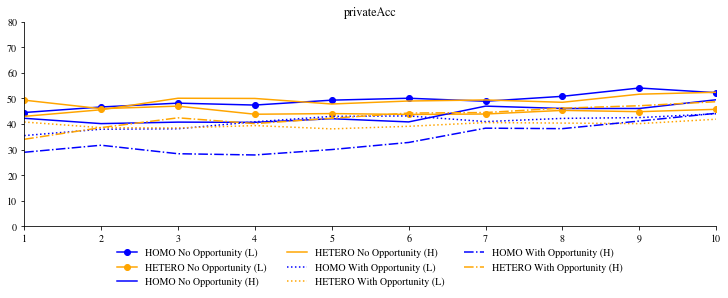

In [127]:
# Private Account 
var_of_interest = 'privateAcc'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community',  'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()
# LocalOnly = group.groupby(['Treatment']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')


axes.set_title(str(var_of_interest))
axes.set_xlim(1,10)
axes.set_ylim(0,80)
axes.legend()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-PrivateAccTimeTrend.pdf'  , bbox_inches="tight")  

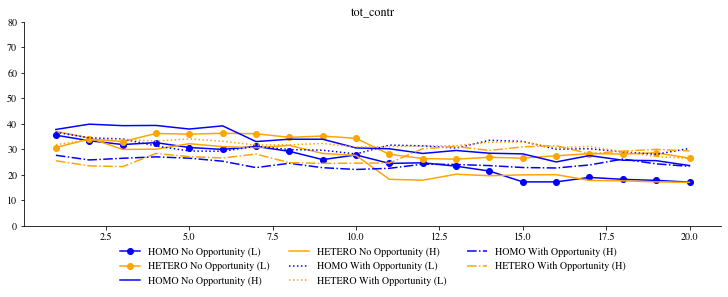

In [159]:
# Total Contribution
var_of_interest = 'tot_contr'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()
# LocalOnly = group.groupby(['Treatment']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
# axes.set_xlim(1,10)
axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)

# fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-LocalContributionTimeTrend.pdf'  , bbox_inches="tight")  

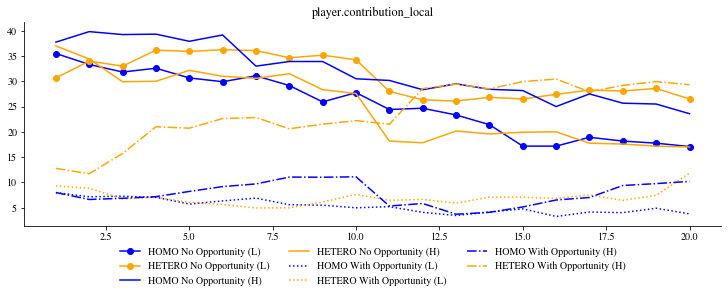

In [160]:
# Local Group Account 
var_of_interest = 'player.contribution_local'

LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
# axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)

# fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-LocalContributionTimeTrend.pdf'  , bbox_inches="tight")  

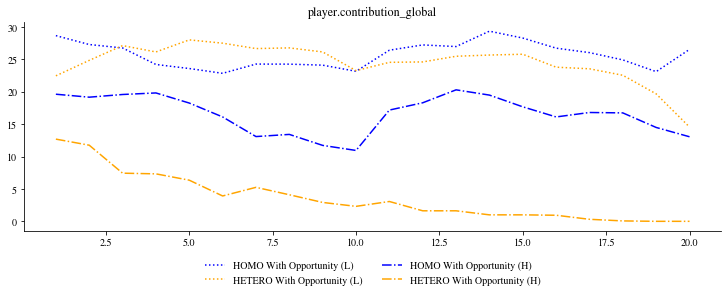

In [161]:
# Global Group Account 
var_of_interest = 'player.contribution_global'

data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()

axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
# axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

# fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-GlobalContributionTimeTrend.pdf'  , bbox_inches="tight")  

In [32]:
LocalOnly

subsession.round_number      1       2       3       4       5       6   \
Treatment FC                                                              
HETERO    20             24.250  24.125  21.625  28.000  28.000  23.250   
          80             39.000  37.000  32.125  32.375  37.000  34.875   
HOMO      20             36.750  34.125  32.250  32.375  28.875  27.125   
          80             44.375  46.000  44.625  43.125  41.375  43.125   

subsession.round_number     7       8       9       10      11      12  \
Treatment FC                                                             
HETERO    20             20.50  19.750  21.000  20.625   8.625   6.125   
          80             34.75  36.875  34.000  34.250  19.875  18.375   
HOMO      20             28.50  24.125  18.875  19.250  13.750  10.000   
          80             37.75  38.750  37.625  32.875  31.750  29.125   

subsession.round_number      13      14      15      16      17      18  \
Treatment FC                                                              
HETERO    20              5.250   5.625   7.250   9.125   9.625  10.250   
          80             19.375  19.250  20.875  20.625  17.000  17.875   
HOMO      20             13.500  11.750   7.625   7.625  10.250   9.625   
          80             30.250  28.625  27.750  23.500  27.500  24.875   

subsession.round_number     19      20  
Treatment FC                            
HETERO    20              8.50  10.250  
          80             18.25  19.250  
HOMO      20              9.00  10.625  
          80             24.75  23.750

In [33]:
LocalWith

subsession.period      1       2       3       4       5       6       7   \
Treatment FC                                                                
HETERO    20       141.25  147.75  157.25  152.75  161.50  156.25  150.75   
          80        76.00   69.75   49.00   49.75   42.50   28.00   34.50   
HOMO      20       169.25  155.75  153.75  137.00  139.75  136.75  141.25   
          80       111.75  111.00  113.50  119.75  116.50  105.75   86.75   

subsession.period      8       9       10      11      12      13      14  \
Treatment FC                                                                
HETERO    20       152.50  151.25  140.00   98.25   98.50  102.00  102.75   
          80        27.50   21.50   18.00   12.25    6.50    6.50    4.00   
HOMO      20       142.75  137.50  136.75  105.75  109.00  108.00  117.50   
          80        84.25   78.75   72.25   68.75   73.25   81.25   78.00   

subsession.period      15      16      17     18     19      20  
Treatment FC                                                     
HETERO    20       103.25   95.25   94.25  90.25  78.75   58.25  
          80         4.00    3.75    1.25   0.25   0.00    0.00  
HOMO      20       113.25  107.00  104.25  99.75  92.50  106.25  
          80        70.75   64.50   67.25  67.00  58.00   52.25

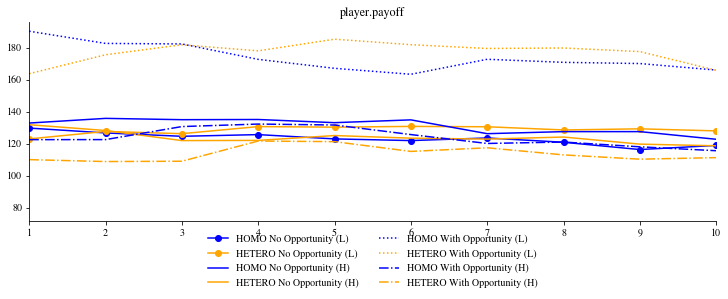

In [139]:
# Payoff 
var_of_interest = 'player.payoff'
# var_of_interest = 'player.join_club'


LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()
axes.plot(LocalOnly.T['HOMO'][20], label='HOMO No Opportunity (L)', c='blue', marker='o')
axes.plot(LocalOnly.T['HETERO'][20], label='HETERO No Opportunity (L)', c='orange', marker='o')
axes.plot(LocalOnly.T['HOMO'][80], label='HOMO No Opportunity (H)', c='blue')
axes.plot(LocalOnly.T['HETERO'][80], label='HETERO No Opportunity (H)', c='orange')
axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-PayoffTimeTrend.pdf'  , bbox_inches="tight")  

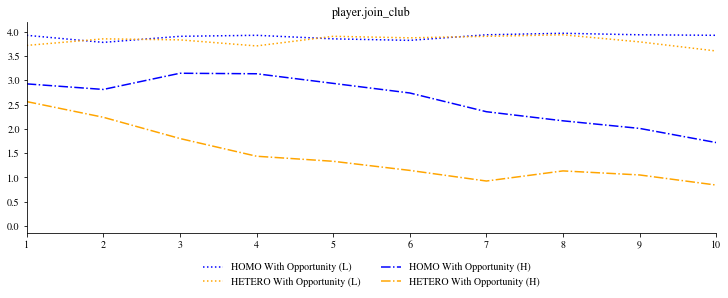

In [144]:
# Payoff 
# var_of_interest = 'player.payoff'
var_of_interest = 'player.join_club'


LocalOnly = pd.pivot_table(data_noOppor, values=var_of_interest, 
                           index=['player.local_community', 'Sequence', 'session.code', 'Treatment','FC'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0).groupby(['Treatment','FC']).mean()
data_Oppor_g = data_Oppor.groupby(['player.local_community', 'Sequence', 'session.code', 
                                   'Treatment','FC','subsession.period', 
                                   'subsession.round_number_o'])[var_of_interest].sum().reset_index()
LocalWith = pd.pivot_table(data_Oppor_g, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'], aggfunc=np.mean, fill_value=0).groupby(['Treatment','FC']).mean()

fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# fig.plot()

axes.plot(LocalWith.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(LocalWith.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(LocalWith.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(LocalWith.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')

axes.set_title(str(var_of_interest))
axes.set_xlim(1,10)
# axes.set_ylim(0,80)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=3, frameon=False)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll5Matches-JoinClubTimeTrend.pdf'  , bbox_inches="tight")  

In [45]:
pd.pivot_table(data_Oppor, values=var_of_interest, 
                           index=['player.local_community',  'session.code', 'Treatment','FC'],
                    columns=['subsession.period'],
#                            columns=['subsession.period'],
                           aggfunc=np.mean, fill_value=np.nan)

subsession.period                                       1         2   \
player.local_community session.code Treatment FC                       
0                      0eg86j32     HOMO      80  0.500000  0.500000   
                       2fgmodqt     HETERO    80  0.666667  0.583333   
                       4pr9j0gm     HOMO      20  1.000000  1.000000   
                       9xes1nai     HETERO    20  0.916667  1.000000   
                       dbs7jo4s     HETERO    20  0.916667  1.000000   
                       ic1q244g     HOMO      20  1.000000  0.916667   
                       xiwi1u7k     HOMO      80  0.916667  0.916667   
                       yguj0voh     HETERO    80  0.583333  0.666667   
1                      0eg86j32     HOMO      80  0.583333  0.500000   
                       2fgmodqt     HETERO    80  0.833333  0.833333   
                       4pr9j0gm     HOMO      20  0.916667  1.000000   
                       9xes1nai     HETERO    20  0.916667  0.833333   
                       dbs7jo4s     HETERO    20  0.916667  0.916667   
                       ic1q244g     HOMO      20  0.916667  1.000000   
                       xiwi1u7k     HOMO      80  0.666667  0.500000   
                       yguj0voh     HETERO    80  0.416667  0.250000   
2                      0eg86j32     HOMO      80  0.916667  0.833333   
                       2fgmodqt     HETERO    80  0.666667  0.333333   
                       4pr9j0gm     HOMO      20  1.000000  1.000000   
                       9xes1nai     HETERO    20  0.916667  1.000000   
                       dbs7jo4s     HETERO    20  0.916667  1.000000   
                       ic1q244g     HOMO      20  1.000000  0.750000   
                       xiwi1u7k     HOMO      80  0.750000  0.833333   
                       yguj0voh     HETERO    80  0.333333  0.583333   
3                      0eg86j32     HOMO      80  0.916667  0.916667   
                       2fgmodqt     HETERO    80  0.833333  0.666667   
                       4pr9j0gm     HOMO      20  1.000000  1.000000   
                       9xes1nai     HETERO    20  1.000000  1.000000   
                       dbs7jo4s     HETERO    20  1.000000  0.916667   
                       ic1q244g     HOMO      20  1.000000  0.750000   
                       xiwi1u7k     HOMO      80  0.416667  0.416667   
                       yguj0voh     HETERO    80  0.833333  0.583333   

subsession.period                                       3         4   \
player.local_community session.code Treatment FC                       
0                      0eg86j32     HOMO      80  0.583333  0.666667   
                       2fgmodqt     HETERO    80  0.250000  0.083333   
                       4pr9j0gm     HOMO      20  1.000000  1.000000   
                       9xes1nai     HETERO    20  0.916667  0.916667   
                       dbs7jo4s     HETERO    20  0.916667  0.916667   
                       ic1q244g     HOMO      20  0.916667  1.000000   
                       xiwi1u7k     HOMO      80  1.000000  0.916667   
                       yguj0voh     HETERO    80  0.666667  0.583333   
1                      0eg86j32     HOMO      80  0.666667  0.666667   
                       2fgmodqt     HETERO    80  0.750000  0.666667   
                       4pr9j0gm     HOMO      20  1.000000  1.000000   
                       9xes1nai     HETERO    20  1.000000  1.000000   
                       dbs7jo4s     HETERO    20  0.916667  0.833333   
                       ic1q244g     HOMO      20  0.916667  1.000000   
                       xiwi1u7k     HOMO      80  0.583333  0.416667   
                       yguj0voh     HETERO    80  0.166667  0.166667   
2                      0eg86j32     HOMO      80  1.000000  1.000000   
                       2fgmodqt     HETERO    80  0.333333  0.416667   
                       4pr9j0gm     HOMO      20  1.000000  1.000000   
                       9xes1nai     HET

In [37]:
var_of_interest =  'player.join_club'
# var_of_interest = 'player.contribution_global'
# var_of_interest = 'player.contribution_local' 
# var_of_interest = 'privateAcc'

LocalGlobal = pd.pivot_table(data_Oppor, values=var_of_interest, 
                    index=['group.id_in_subsession',  'session.code', 'Treatment','subsession.sg', 'FC' ],
                    columns=['subsession.period'], aggfunc=np.mean)


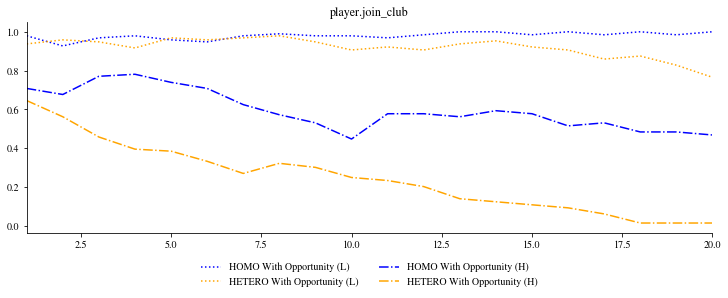

In [38]:
SuperGames = LocalGlobal.groupby(['Treatment','FC']).mean()
SuperGames
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
# # fig.plot()
axes.plot(SuperGames.T['HOMO'][20], label='HOMO With Opportunity (L)', c='blue', ls=':')
axes.plot(SuperGames.T['HETERO'][20], label='HETERO With Opportunity (L)', c='orange',ls=':')
axes.plot(SuperGames.T['HOMO'][80], label='HOMO With Opportunity (H)', c='blue', ls='-.')
axes.plot(SuperGames.T['HETERO'][80], label='HETERO With Opportunity (H)', c='orange',ls='-.')
axes.set_title(str(var_of_interest))
axes.set_xlim(1,20)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(bbox_to_anchor=(.5,-0.2), loc="center" , ncol=2, frameon=False)

fig.savefig('..\\Output\\01-clean-data-Dec-2022-ConsiderAll3Matches-JoinClubTimeTrend.pdf'  , bbox_inches="tight")  

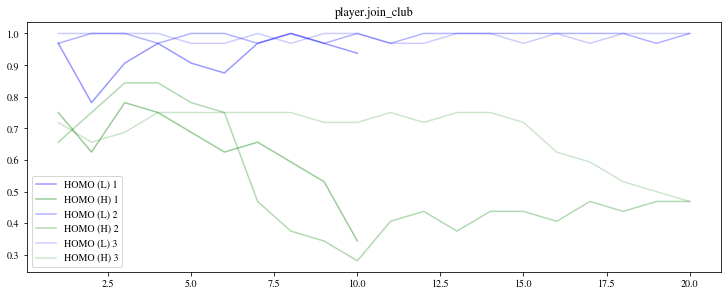

In [39]:
SuperGames = LocalGlobal.groupby(['Treatment','FC','subsession.sg']).mean()
SuperGames
fig, axes = plt.subplots(nrows=1, ncols=1,  sharex=True,  sharey=True, constrained_layout=True, figsize=(10, 4))
for i in range(1,4):
    axes.plot(SuperGames.T['HOMO'][20][i], label='HOMO (L) '+str(i), c='blue', alpha=0.05*(10-2*i))
#     axes.plot(SuperGames.T['HETERO'][20][i], label='HETERO (L) '+str(i), c='orange',alpha=0.05*(10-2*i))
    axes.plot(SuperGames.T['HOMO'][80][i], label='HOMO (H) '+str(i), c='green', alpha=0.05*(10-2*i))
#     axes.plot(SuperGames.T['HETERO'][80][i], label='HETERO (H) '+str(i), c='red', alpha=0.05*(10-2*i))
axes.set_title(str(var_of_interest))
axes.legend()

In [40]:
col_WOpp = 'PGSO_08_WithClubOppVariedCost_Part3'
col_names = [col_WOpp+'.'+str(1)+'.'+ x for x in variables]
col_rename = {}
for x in variables:
    col_rename[col_WOpp+'.'+str(1)+'.'+ x ] =  x
temp = data[col_names]
temp = temp.rename(columns=col_rename) 
data_WOppor = temp
# data_noOppor = []
for i in range(2,11):
    col_names = [col_WOpp+'.'+str(i)+'.'+ x for x in variables]
    col_rename = {}
    for x in variables:
        col_rename[col_WOpp+'.'+str(i)+'.'+ x ] =  x
    temp = data[col_names]
    temp = temp.rename(columns=col_rename) 
    data_WOppor = data_WOppor.append(temp, ignore_index=True)
    
LocalGlobal_l = pd.pivot_table(data_WOppor, values='player.contribution_local', index=['player.local_community'],
                    columns=['subsession.round_number'], aggfunc=np.sum, fill_value=0)
LocalGlobal_l

KeyError: "None of [Index(['PGSO_08_WithClubOppVariedCost_Part3.1.subsession.round_number',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.subsession.period',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.subsession.sg',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.player.id_in_group',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.player.endowment',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.player.join_club',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.player.local_community',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.player.id_in_local',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.player.contribution_local',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.player.contribution_global',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.player.total_contribution_local',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.player.individual_share_local',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.player.payoff',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.group.id_in_subsession',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.group.FC',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.group.total_contribution_global',\n       'PGSO_08_WithClubOppVariedCost_Part3.1.group.individual_share_global'],\n      dtype='object')] are in the [columns]"

In [41]:
LocalGlobal_gF = pd.pivot_table(data_WOppor, values=[
                                            'player.join_club',
                                                     'player.contribution_local', 
                                                     'player.contribution_global'],
                                index=['subsession.round_number'],
                    columns=['player.local_community','group.id_in_subsession', 'group.FC' ], aggfunc=np.sum, fill_value=0)
LocalGlobal_gF

NameError: name 'data_WOppor' is not defined

In [204]:
LocalGlobal_gF2 = pd.pivot_table(data_WOppor, values=[
                                            'group.total_contribution_global'],
                                index=['subsession.round_number'],
                    columns=['player.local_community','group.id_in_subsession', 'group.FC' ], aggfunc=np.mean, fill_value=0)
LocalGlobal_gF2

NameError: name 'data_WOppor' is not defined

In [205]:
condition = (data_WOppor['subsession.round_number'] == 2 )  & (data_WOppor['group.id_in_subsession'] == 2 )
data_WOppor[condition]

NameError: name 'data_WOppor' is not defined

# Check page time



In [ ]:
# Some useful code in the past

In [3]:
sessions = {
            'all_apps_wide_2022-11-04.csv':['pilot_1',125,'DynamicPower_05_Experiment.','T6 END',4], 
        
    
    
           }

rows = {}

nRows = 0
for i,s in enumerate(sessions):
    print("------------")
    print(s)
    data=pd.read_csv('..\\RawData\\'+s)
    sessions[s].append(nRows)
    nRows += data.shape[0]
    sessions[s].append(nRows)
    if not sessions[s][3] in rows:
        rows[sessions[s][3]]=np.arange(sessions[s][5],sessions[s][6])
    else:
        rows[sessions[s][3]]=np.concatenate([rows[sessions[s][3]],np.arange(sessions[s][5],sessions[s][6])])

sessions

#session dictionary
#session file : [sequence, experiment label within file, start row, end row + 1]

------------
2022_02_11_pilot_session1.csv
------------
2022_02_18_pilot_session2.csv
------------
2022_02_23_pilot_session3.csv
------------
2022_02_28_pilot_session4.csv
------------
2022_02_28_pilot_session5.csv
------------
2022_03_02_pilot_session6.csv
------------
2022_03_08_pilot_session7.csv
------------
2022_03_08_pilot_session8.csv
------------
2022_03_09_pilot_session9.csv
------------
2022_03_09_pilot_session10.csv
------------
2022_03_22_pilot_session11.csv
------------
2022_03_22_pilot_session12.csv
------------
2022_03_23_pilot_session13.csv
------------
2022_03_23_pilot_session14.csv
------------
2022_04_05_real_session1a.csv
------------
2022_04_05_real_session1b.csv
------------
2022_04_05_real_session2a.csv
------------
2022_04_05_real_session2b.csv
------------
2022_04_05_real_session3.csv
------------
2022_04_07_real_session4b.csv
------------
2022_04_07_real_session4a.csv
------------
2022_04_08_real_session5.csv
------------
2022_04_08_real_session5_5(wrongT5X).c

{'2022_02_11_pilot_session1.csv': ['pilot_1',
  125,
  'DynamicPower_05_Experiment.',
  'T6 END',
  4,
  0,
  16],
 '2022_02_18_pilot_session2.csv': ['pilot_2',
  125,
  'DynamicPower_05_Experiment.',
  'T6 END',
  4,
  16,
  32],
 '2022_02_23_pilot_session3.csv': ['pilot_3',
  125,
  'DynamicPower_05_Experiment.',
  'T6 END',
  4,
  32,
  48],
 '2022_02_28_pilot_session4.csv': ['pilot_4',
  60,
  'DynamicPower_05_Experiment.',
  'T6 END',
  4,
  48,
  72],
 '2022_02_28_pilot_session5.csv': ['pilot_5',
  60,
  'DynamicPower_05_Experiment.',
  'T6 END',
  4,
  72,
  88],
 '2022_03_02_pilot_session6.csv': ['pilot_6',
  60,
  'DynamicPower_05_Experiment.',
  'T6 END',
  4,
  88,
  108],
 '2022_03_08_pilot_session7.csv': ['pilot_7',
  60,
  'DynamicPower_05_Experiment.',
  'T1 EXO',
  2,
  108,
  132],
 '2022_03_08_pilot_session8.csv': ['pilot_8',
  60,
  'DynamicPower_05_Experiment.',
  'T1 EXO',
  2,
  132,
  148],
 '2022_03_09_pilot_session9.csv': ['pilot_9',
  60,
  'DynamicPower_05_Ex

In [4]:
rows

{'T6 END': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107]),
 'T1 EXO': array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
 

In [5]:
columns = [ '.group.matchNumber','.group.roundNumber','.group.id_in_subsession','.player.id_in_group',
            '.player.myChoice','.player.myPayoff','.player.roundPayoff','.player.myPower',
              '.player.myBelief_firstX', '.player.myBelief_secondX', '.player.myBelief_thirdX',
          '.player.myPNorm_X', '.player.myPNorm_Y', '.player.mySNorm_X', '.player.mySNorm_Y',
          '.player.myEffort',
          '.group.total_contribution', 
          '.player.calculatorHistory3', '.player.calculatorHistory4','.player.calculatorHistory5','.player.calculatorHistory6','.player.calculatorHistory8'
          ]

additional_columns = ['participant.code','session.code','treatment', 'session']

ncols = 272

out = {}
for col in additional_columns+columns:
    out[col]=np.empty((nRows,ncols))
    out[col][:]=np.nan

In [6]:
# for j,part_name in enumerate(['part2_play.','part3_play.']):

j=0
for i,s in enumerate(sessions):
    
    print(s)
    data=pd.read_csv('..\\RawData\\'+s)
    start_row = sessions[s][5]
    end_row = sessions[s][6]
    part_name = sessions[s][2]
    ncols = sessions[s][1]

    for col in columns:
        #part2 group qualification
        if i==0 and col=='.player.roundPayoff':
            pass
        else:
            colnames = [part_name+str(x)+col for x in range(1,ncols+1)]
            temp=data[colnames].to_numpy()
            if type(temp[0][0])==str:
                out[col]=out[col].astype(str)
            out[col][start_row:end_row,0:ncols]=temp

    #sessionID
    colnames = ['session.code' for x in range(1,ncols+1)]
    temp=data[colnames].to_numpy()
    if type(temp[0][0])==str:
        out['session.code']=out['session.code'].astype(str)
    out['session.code'][start_row:end_row,0:ncols]=temp
    
    #subjectID
    colnames = ['participant.code' for x in range(1,ncols+1)]
    temp=data[colnames].to_numpy()
    if type(temp[0][0])==str:
        out['participant.code']=out['participant.code'].astype(str)
    out['participant.code'][start_row:end_row,0:ncols]=temp
    
    #treatment
    temp=sessions[s][3]
    if type(temp)==str:
        out['treatment']=out['treatment'].astype(str)
    out['treatment'][start_row:end_row,0:ncols]=temp
    
    #session name 
    temp = sessions[s][0]
    if type(temp)==str:
        out['session']=out['session'].astype(str)
    out['session'][start_row:end_row,0:ncols]=temp

2022_02_11_pilot_session1.csv
2022_02_18_pilot_session2.csv
2022_02_23_pilot_session3.csv
2022_02_28_pilot_session4.csv
2022_02_28_pilot_session5.csv
2022_03_02_pilot_session6.csv
2022_03_08_pilot_session7.csv
2022_03_08_pilot_session8.csv
2022_03_09_pilot_session9.csv
2022_03_09_pilot_session10.csv
2022_03_22_pilot_session11.csv
2022_03_22_pilot_session12.csv
2022_03_23_pilot_session13.csv
2022_03_23_pilot_session14.csv
2022_04_05_real_session1a.csv
2022_04_05_real_session1b.csv
2022_04_05_real_session2a.csv
2022_04_05_real_session2b.csv
2022_04_05_real_session3.csv
2022_04_07_real_session4b.csv
2022_04_07_real_session4a.csv
2022_04_08_real_session5.csv
2022_04_08_real_session5_5(wrongT5X).csv
2022_04_11_real_session6.csv
2022_04_11_real_session7.csv
2022_04_11_real_session8.csv
2022_04_11_real_session9.csv
2022_04_11_real_session10.csv
2022_04_12_real_session11a.csv
2022_04_12_real_session11b.csv
2022_04_14_real_session12a.csv
2022_04_14_real_session12b.csv
2022_04_22_real_session13a

In [7]:
for col in out:
    out[col]=out[col].flatten()

In [8]:
out_data = pd.DataFrame(out)
# Drop when myChoice==-1
out_data = out_data[out_data['.player.myChoice']!=-1]
# Drop nan
out_data = out_data[~out_data['.group.matchNumber'].isnull()]
# Drop first session, match7-10
out_data = out_data.drop(out_data[ (out_data['session']=='pilot_1' ) & (out_data['.group.matchNumber'] >= 7 )].index)

# Added on May 22nd: 
#Drop 10 observations where the group contribution is not recorded correctly (end of crashed program, problematic)
out_data['group_total_contribution_check'] = out_data.groupby(['session.code', '.group.id_in_subsession', '.group.matchNumber', '.group.roundNumber',])['.player.myChoice'].transform('sum')

out_data = out_data.drop(out_data[out_data['group_total_contribution_check']!=out_data['.group.total_contribution']].index)
out_data.to_csv("01-clean-data-may-2022.csv",index=False)

In [9]:
# len(out_data['participant.code'].unique())
len(out_data['session.code'].unique())

34

In [12]:
len(out_data['session'].unique())

34

In [15]:
out_data['session'].unique()

array(['pilot_1', 'pilot_2', 'pilot_3', 'pilot_4', 'pilot_5', 'pilot_6',
       'pilot_7', 'pilot_8', 'pilot_9', 'pilot_10', 'pilot_11',
       'pilot_12', 'pilot_13', 'pilot_14', 'real_1a', 'real_1b',
       'real_2a', 'real_2b', 'real_3', 'real_4b', 'real_4a', 'real_5',
       'real_5_extra', 'real_6', 'real_7', 'real_8', 'real_9', 'real_10',
       'real_11a', 'real_11b', 'real_12a', 'real_12b', 'real_13a',
       'real_13b'], dtype=object)